## Week 3: Genome-wide association studies (GWAS)

Our live-coding GWAS is adapted from workshop by Heather Wheeler from Loyola University Chicago (https://github.com/hwheeler01/GWAS_workshop). The premise for the exercise is that you are part of a company developing a new cancer drug called GS451. Some individuals in early phase trials have experienced a side effect of the drug called lymphocytopenia (low lymphocyte counts). You are now tasked with performing a GWAS on data from lymphblastoid cell lines to search for risk factors for lymphocytopenia. The phenotype that was measured is the IC$_{50}$, defined as the concentration of the drug at which 50% viability occurs.

Genotype data are available in VCF format [`genotypes.vcf`](https://www.dropbox.com/s/6e0vhffv6mcfy9l/genotypes.vcf?dl=0), with which you should be familiar from last week. Phenotype data are available as a text file [`GS451_IC50.txt`](https://www.dropbox.com/s/cvznmgbip40plkb/GS451_IC50.txt?dl=0).

The software package PLINK is widely used for genome-wide association and related analyses. We need to install PLINK by typing into the terminal:

```
conda install plink -y
```

How many genetic variants (in this case SNPs) are present in our VCF file? Note that the `%` symbol allows us to run shell commands within a jupyter notebook.

In [1]:
%%bash
cat /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf | grep -v "^#" | wc -l

  256896


### Linkage disequilibrium

Linkage disequlibrium refers to correlation among genotypes at multiple sites in the genome. This is a consequence of the fact that chromosomes are transmitted in “chunks” through the generations. When mutations arise, they arise on a single chromosome with a given set of alleles and are thus associated with genetic background unless they become shuffled during the process of meiotic recombination. A set of alleles that tend to occur together because of linkage disequilibrium are called a “haplotype”.

As a result of linkage disequilibrium, knowledge of genotype at one site in the genome can be informative of genotype at another site despite the fact that the second site was not actually genotyped. Using prior knowledge of linkage disequilibrium to “fill in” missing genotype information is a process called “imputation”.

The existence of linkage disequilibrium also means that correlation between genotype at a particular site in the genome and phenotype (e.g., disease outcome) does not imply causation. Even ignoring other possible confounders, linkage disequilibrium means that any variant on the same haplotype could be driving the association. Beyond mutation and recombination, other evolutionary forces such as gene flow, genetic drift, and natural selection can also influence patterns of linkage disequilibrium observed in population genetic data. Measuring linkage disequilibrium is therefore important for both medical and evolutionary studies.

We can use PLINK to compute measures of pairwise linkage disequilibrium. Let's try for two adjacent SNPs that I have pre-selected.

In [2]:
%%bash
plink --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf --ld rs11102465 rs12061372

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --ld rs11102465 rs12061372
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 176 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%

Let's try for two distant alleles:

In [3]:
%%bash
plink --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf --ld rs9699599 rs7120398

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --ld rs9699599 rs7120398
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 176 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%4

### Association testing "by hand"

Note that the test for association between each SNP and a phenotype of interest is generally just some form of linear regression. For continuous traits, we commonly use OLS, while for case/control studies, we often perform logistic regression (a form of generalized linear model). To prove this concept for you, let's implement the association test that is used by PLINK, under the hood. Remember, the test is applied to a single SNP at a time.

First, let's convert the PLINK file to a rectangular format that is easier to parse:

In [4]:
%%bash
plink --vcf ~/Dropbox/teaching/qblab_week3/genotypes.vcf --recodeA --snp rs11102465 --out rs11102465

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recodeA flag deprecated.  Use "--recode A ...".
Logging to rs11102465.log.
Options in effect:
  --out rs11102465
  --recode A
  --snp rs11102465
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: rs11102465-temporary.bed + rs11102465-temporary.bim +
rs11102465-temporary.fam written.
1 out of 256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to rs11102465.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 176 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%2

In [5]:
%%bash
cat rs11102465.raw

FID IID PAT MAT SEX PHENOTYPE rs11102465_G
1001 1001 0 0 0 -9 1
1002 1002 0 0 0 -9 2
1003 1003 0 0 0 -9 NA
1004 1004 0 0 0 -9 1
1005 1005 0 0 0 -9 0
1006 1006 0 0 0 -9 1
1007 1007 0 0 0 -9 0
1008 1008 0 0 0 -9 0
1009 1009 0 0 0 -9 0
1010 1010 0 0 0 -9 0
1011 1011 0 0 0 -9 1
1012 1012 0 0 0 -9 1
1013 1013 0 0 0 -9 1
1014 1014 0 0 0 -9 0
1015 1015 0 0 0 -9 1
1016 1016 0 0 0 -9 NA
1017 1017 0 0 0 -9 NA
1018 1018 0 0 0 -9 NA
1019 1019 0 0 0 -9 0
1020 1020 0 0 0 -9 0
1021 1021 0 0 0 -9 0
1022 1022 0 0 0 -9 0
1023 1023 0 0 0 -9 0
1024 1024 0 0 0 -9 0
1025 1025 0 0 0 -9 0
1026 1026 0 0 0 -9 NA
1027 1027 0 0 0 -9 0
1028 1028 0 0 0 -9 0
1029 1029 0 0 0 -9 0
1030 1030 0 0 0 -9 1
1031 1031 0 0 0 -9 0
1032 1032 0 0 0 -9 0
1033 1033 0 0 0 -9 1
1034 1034 0 0 0 -9 1
1035 1035 0 0 0 -9 NA
1036 1036 0 0 0 -9 1
1037 1037 0 0 0 -9 0
1038 1038 0 0 0 -9 0
1039 1039 0 0 0 -9 1
1040 1040 0 0 0 -9 1
1041 1041 0 0 0 -9 0
1042 1042 0 0 0 -9 2
1043 1043 0 0 0 -9 0
1044 1044 0 0 0 -9 0
1045 1045 0 0 0 -9 0
1046 1

In [6]:
%%bash
cat /Users/rajivmccoy/Dropbox/teaching/qblab_week3/GS451_IC50.txt

FID	IID	GS451_IC50
1001	1001	5.594255712
1002	1002	8.52563251
1003	1003	12.7367394
1004	1004	12.17520147
1005	1005	9.93674223
1006	1006	9.16348291
1007	1007	11.0675103
1008	1008	9.388757402
1009	1009	3.238702498
1010	1010	7.410126906
1011	1011	8.247488725
1012	1012	7.410126906
1013	1013	4.562876989
1014	1014	7.51073731
1015	1015	3.65872649
1016	1016	8.521603171
1017	1017	12.31573863
1018	1018	2.931132591
1019	1019	6.90646442
1020	1020	NA
1021	1021	4.691692501
1022	1022	6.18448709
1023	1023	5.865317681
1024	1024	4.306711194
1025	1025	3.067151991
1026	1026	7.381921779
1027	1027	5.705977193
1028	1028	3.885954612
1029	1029	4.46312131
1030	1030	7.170078283
1031	1031	4.703169902
1032	1032	3.993402611
1033	1033	4.700972107
1034	1034	3.965807993
1035	1035	4.60695511
1036	1036	7.137477588
1037	1037	5.047736112
1038	1038	3.889007105
1039	1039	8.920259686
1040	1040	5.829908701
1041	1041	7.577281787
1042	1042	4.776063607
1043	1043	6.941629188
1044	1044	4.4533533
1045	1045	5.083755584
1046	1046	4.8

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf

genotype = pd.read_csv('rs11102465.raw', sep = " ")
genotype['subject_id'] = genotype['FID'].astype(str) + "_" + genotype['IID'].astype(str)
genotype

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs11102465_G,subject_id
0,1001,1001,0,0,0,-9,1.0,1001_1001
1,1002,1002,0,0,0,-9,2.0,1002_1002
2,1003,1003,0,0,0,-9,NaN,1003_1003
3,1004,1004,0,0,0,-9,1.0,1004_1004
4,1005,1005,0,0,0,-9,0.0,1005_1005
...,...,...,...,...,...,...,...,...
171,1172,1172,0,0,0,-9,0.0,1172_1172
172,1173,1173,0,0,0,-9,0.0,1173_1173
173,1174,1174,0,0,0,-9,0.0,1174_1174
174,1175,1175,0,0,0,-9,0.0,1175_1175


In [8]:
phenotype = pd.read_csv('/Users/rajivmccoy/Dropbox/teaching/qblab_week3/GS451_IC50.txt', sep = "\t")
phenotype['subject_id'] = phenotype['FID'].astype(str) + "_" + phenotype['IID'].astype(str)
phenotype

,FID,IID,GS451_IC50,subject_id
0,1001,1001,5.594256,1001_1001
1,1002,1002,8.525633,1002_1002
2,1003,1003,12.736739,1003_1003
3,1004,1004,12.175201,1004_1004
4,1005,1005,9.936742,1005_1005
...,...,...,...,...
171,1172,1172,5.724618,1172_1172
172,1173,1173,5.603924,1173_1173
173,1174,1174,7.064706,1174_1174
174,1175,1175,6.715907,1175_1175


In [9]:
assoc_input = pd.merge(genotype, phenotype, on = "subject_id")
assoc_input

,FID_x,IID_x,PAT,MAT,SEX,PHENOTYPE,rs11102465_G,subject_id,FID_y,IID_y,GS451_IC50
0,1001,1001,0,0,0,-9,1.0,1001_1001,1001,1001,5.594256
1,1002,1002,0,0,0,-9,2.0,1002_1002,1002,1002,8.525633
2,1003,1003,0,0,0,-9,NaN,1003_1003,1003,1003,12.736739
3,1004,1004,0,0,0,-9,1.0,1004_1004,1004,1004,12.175201
4,1005,1005,0,0,0,-9,0.0,1005_1005,1005,1005,9.936742
...,...,...,...,...,...,...,...,...,...,...,...
171,1172,1172,0,0,0,-9,0.0,1172_1172,1172,1172,5.724618
172,1173,1173,0,0,0,-9,0.0,1173_1173,1173,1173,5.603924
173,1174,1174,0,0,0,-9,0.0,1174_1174,1174,1174,7.064706
174,1175,1175,0,0,0,-9,0.0,1175_1175,1175,1175,6.715907


In [10]:
model = smf.ols(formula = "GS451_IC50 ~ rs11102465_G", data = assoc_input)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             GS451_IC50   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3593
Date:                Fri, 25 Sep 2020   Prob (F-statistic):              0.550
Time:                        00:45:57   Log-Likelihood:                -366.71
No. Observations:                 166   AIC:                             737.4
Df Residuals:                     164   BIC:                             743.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.2902      0.223     28.194      0.000       5.850       6.731
rs11102465_G     0.1723      0.287      0.599      0.550      -0.395       0.740
==============================================================================
Omnibus:                       14.482   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.062
Skew:                           0.759   Prob(JB):                     0.000325
Kurtosis:                       3.137   Cond. No.                         2.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Association testing "by PLINK"

Now let's do the exact same association test for the same SNP using PLINK:

In [11]:
%%bash
plink \
  --vcf ~/Dropbox/teaching/qblab_week3/genotypes.vcf \
  --snp rs11102465 \
  --pheno ~/Dropbox/teaching/qblab_week3/GS451_IC50.txt \
  --assoc \
  --allow-no-sex

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --allow-no-sex
  --assoc
  --pheno /Users/rajivmccoy/Dropbox/teaching/qblab_week3/GS451_IC50.txt
  --snp rs11102465
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
1 out of 256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
175 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 176 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%2

In [12]:
%%bash
head plink.qassoc

 CHR          SNP         BP    NMISS       BETA         SE         R2        T            P 
   1   rs11102465  112705618      166     0.1723     0.2875   0.002186   0.5994       0.5497 


But this is not yet a genome-wide association study. To apply this to **all** genotyped variants, we omit the `--snp` argument.

In [13]:
%%bash
plink \
  --vcf ~/Dropbox/teaching/qblab_week3/genotypes.vcf \
  --pheno ~/Dropbox/teaching/qblab_week3/GS451_IC50.txt \
  --assoc \
  --allow-no-sex

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --allow-no-sex
  --assoc
  --pheno /Users/rajivmccoy/Dropbox/teaching/qblab_week3/GS451_IC50.txt
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
175 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 176 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%

In [14]:
%%bash
head plink.qassoc

 CHR         SNP         BP    NMISS       BETA         SE         R2        T            P 
   1   rs9699599     558185       85      1.385       0.68    0.04757    2.036      0.04493 
   1  rs12138618     740098       86    -0.2962     0.9281   0.001211  -0.3191       0.7504 
   1   rs3131969     744045      164     0.2357     0.2673   0.004777   0.8818       0.3792 
   1   rs6672353     767376       85     0.2122     0.6867   0.001149    0.309       0.7581 
   1  rs13302982     851671      166      0.296      0.266   0.007497    1.113       0.2673 
   1   rs3121567     933331      166    -0.2934     0.2443    0.00872   -1.201       0.2314 
   1   rs6667248    1007079      166    -0.2285     0.2872   0.003843  -0.7954       0.4275 
   1   rs3766191    1007450      166    0.01377     0.2935  1.343e-05  0.04694       0.9626 
   1   rs6700376    1079693      173     0.3996     0.2616    0.01346    1.527       0.1285 


In [15]:
%%bash
sort -k9,9g plink.qassoc | head

 CHR         SNP         BP    NMISS       BETA         SE         R2        T            P 
  19   rs7257475   20372113       88     -3.008     0.4375     0.3547   -6.876    9.311e-10 
  19  rs10413538   20370690       86     -3.026     0.4447     0.3554   -6.805    1.395e-09 
  21   rs2826383   20844081      166      3.031     0.5166     0.1734    5.866    2.392e-08 
  19  rs12972967   20358400       89     -2.421     0.4077     0.2885   -5.939     5.76e-08 
   2   rs1358578   51626897      166      2.111     0.3977     0.1466    5.307    3.571e-07 
  17   rs3094508   33137048       89      3.532     0.6754     0.2392     5.23    1.156e-06 
   2   rs1582657  107458116      163      1.329     0.2662     0.1341    4.993     1.53e-06 
   4   rs1562152  144999541       89      3.171     0.6174     0.2326    5.135    1.704e-06 
   2  rs10170982  101592772      173     -1.825     0.3717     0.1236    -4.91     2.11e-06 


Do any of these variants achieve genome-wide significance?

### Dealing with population stratification

One major concern in genome-wide association studies is violation of the regression assumption of independent data points due to genetic relatedness and/or population structure. This can generate false associations, especially if the mean value of the trait varies by population. One common approach to mitigate this effect is to use principal component analysis to infer ancestry of the individuals in the study and use these top principal components (the eigenvectors) as covariates in the regression analysis. PLINK can be used to perform PCA:

In [22]:
%%bash
plink \
  --vcf ~/Dropbox/teaching/qblab_week3/genotypes.vcf \
  --pca \
  --mind

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --mind
  --pca
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
9 people removed due to missing genotype data (--mind).
IDs written to plink.irem .
Using up to 11 threads (change this with --threads).
Before main variant filters, 167 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34

In [23]:
%%bash
head plink.eigenvec

1001 1001 -0.00444256 -0.0180967 0.0320993 0.00635929 0.0209201 -0.0189918 -0.00038697 0.00798011 -0.00117683 -0.00612412 -0.0231559 0.00077822 -0.0163231 0.00573849 -0.0294811 0.0245982 0.0330938 -0.0101848 -0.0312229 -0.0111747
1002 1002 -0.00069263 -0.0222195 0.0353091 0.00421928 0.0259683 -0.0129825 -0.0011083 0.00713626 0.000331146 -0.00484864 -0.0233351 0.000147049 -0.0156179 0.0108475 -0.0206654 0.0331346 0.0373225 -0.00807964 -0.0321347 -0.0154979
1004 1004 0.0325723 0.0481097 0.0450541 0.10695 -0.0615774 -0.0601499 0.110974 -0.212354 -0.0872064 0.129804 -0.0544519 -0.0515996 0.00724586 -0.00174528 0.1205 -0.212473 -0.0294028 0.228895 0.0805939 -0.028241
1005 1005 0.0230683 0.0300442 0.0309081 0.0848727 -0.0483072 -0.0349272 0.0706501 -0.151764 -0.0701441 0.0916992 -0.0445925 -0.0319689 -0.00643486 -0.00421891 0.0850025 -0.158268 -0.0215372 0.16344 0.0585905 -0.0155805
1006 1006 0.0250071 0.0386566 0.0348867 0.0710545 -0.0500304 -0.0424975 0.0846845 -0.148222 -0.0568944 0.09564

The resulting top PCs can then be used as covariates in the GWAS. This amounts to a multiple regression test, where genotype and the top PCs are all specified as predictors of the phenotype. PLINK distinguishes simple linear regression from multiple linear regression using the `--assoc` versus `--linear` flags, respectively. Covariates are provided by including `--covar plink.eigenvec` and specifying the (one-based) column indices of the covariates you want to include, e.g., `--covar-number 1-5` for the top 5 PCs.

In [27]:
%%bash
plink \
  --vcf ~/Dropbox/teaching/qblab_week3/genotypes.vcf \
  --pheno ~/Dropbox/teaching/qblab_week3/GS451_IC50.txt \
  --linear \
  --allow-no-sex \
  --covar plink.eigenvec \
  --covar-number 1-5

PLINK v1.90p 64-bit (16 Jun 2020)              www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --allow-no-sex
  --covar plink.eigenvec
  --covar-number 1-5
  --linear
  --pheno /Users/rajivmccoy/Dropbox/teaching/qblab_week3/GS451_IC50.txt
  --vcf /Users/rajivmccoy/Dropbox/teaching/qblab_week3/genotypes.vcf

16384 MB RAM detected; reserving 8192 MB for main workspace.
--vcf: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam written.
256896 variants loaded from .bim file.
176 people (0 males, 0 females, 176 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
175 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
--covar: 5 out of 20 covariates loaded.
9 people were not seen in the covariate file.
Before main variant filters, 176 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%

In [28]:
%%bash
grep 'ADD' plink.assoc.linear | sort -k9,9g | head

   2  rs10170982  101592772    T        ADD      165      -1.93       -5.676    6.419e-08
   2  rs17025871  101600219    T        ADD      166     -1.787       -5.458    1.819e-07
   2  rs10186803  101594055    C        ADD      166     -1.838       -5.402    2.366e-07
   2  rs12622974  101600032    G        ADD      166     -1.838       -5.402    2.366e-07
   2  rs13394005  101600574    G        ADD      165     -1.832       -5.365    2.834e-07
  19   rs7257475   20372113    T        ADD       79     -2.465       -5.253    1.456e-06
  19  rs10413538   20370690    T        ADD       77     -2.487       -5.223     1.73e-06
  21   rs2826383   20844081    A        ADD      166      2.534        4.852    2.897e-06
  10  rs10886150  119580089    C        ADD      166     -1.484         -4.8    3.639e-06
   4   rs1562152  144999541    T        ADD       80      3.062        4.844    6.934e-06


### Manhattan plot

In [41]:
# split columns on any number of spaces
gwas = pd.read_csv("plink.qassoc", sep = "\s+")

gwas['logP'] = -1 * np.log10(gwas['P'])
gwas['snp_index'] = range(len(gwas))
gwas

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P,logP,snp_index
0,1,rs9699599,558185,85,1.3850,0.6800,0.047570,2.0360,0.04493,1.347464,0
1,1,rs12138618,740098,86,-0.2962,0.9281,0.001211,-0.3191,0.75040,0.124707,1
2,1,rs3131969,744045,164,0.2357,0.2673,0.004777,0.8818,0.37920,0.421132,2
3,1,rs6672353,767376,85,0.2122,0.6867,0.001149,0.3090,0.75810,0.120274,3
4,1,rs13302982,851671,166,0.2960,0.2660,0.007497,1.1130,0.26730,0.573001,4
...,...,...,...,...,...,...,...,...,...,...,...
256891,22,rs762672,49411684,166,-0.4585,0.2921,0.014800,-1.5700,0.11840,0.926648,256891
256892,22,rs131711,49417023,80,-1.2380,0.7697,0.032110,-1.6090,0.11170,0.951947,256892
256893,22,rs2341011,49486501,175,-0.3644,0.2604,0.011200,-1.4000,0.16340,0.786748,256893
256894,22,rs9628187,49503532,166,0.0425,0.2990,0.000123,0.1421,0.88710,0.052027,256894


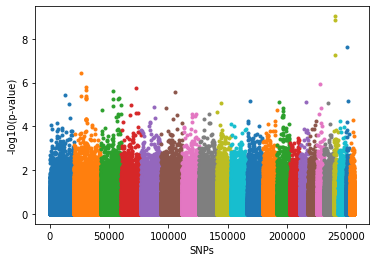

In [42]:
import matplotlib.pyplot as plt

gwas['snp_index'] = range(len(gwas))

fig, ax = plt.subplots()

for chr in range(1, 23): 
    ax.scatter(gwas["snp_index"][gwas["CHR"] == chr], gwas["logP"][gwas["CHR"] == chr], marker = '.')

plt.xlabel("SNPs")
plt.ylabel("-log10(p-value)")
    
plt.show()


### QQ plot

In [43]:
gwas

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P,logP,snp_index
0,1,rs9699599,558185,85,1.3850,0.6800,0.047570,2.0360,0.04493,1.347464,0
1,1,rs12138618,740098,86,-0.2962,0.9281,0.001211,-0.3191,0.75040,0.124707,1
2,1,rs3131969,744045,164,0.2357,0.2673,0.004777,0.8818,0.37920,0.421132,2
3,1,rs6672353,767376,85,0.2122,0.6867,0.001149,0.3090,0.75810,0.120274,3
4,1,rs13302982,851671,166,0.2960,0.2660,0.007497,1.1130,0.26730,0.573001,4
...,...,...,...,...,...,...,...,...,...,...,...
256891,22,rs762672,49411684,166,-0.4585,0.2921,0.014800,-1.5700,0.11840,0.926648,256891
256892,22,rs131711,49417023,80,-1.2380,0.7697,0.032110,-1.6090,0.11170,0.951947,256892
256893,22,rs2341011,49486501,175,-0.3644,0.2604,0.011200,-1.4000,0.16340,0.786748,256893
256894,22,rs9628187,49503532,166,0.0425,0.2990,0.000123,0.1421,0.88710,0.052027,256894


In [44]:
gwas_sorted = gwas.sort_values(by = "P")
gwas_sorted

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P,logP,snp_index
240915,19,rs7257475,20372113,88,-3.008000,0.4375,3.547000e-01,-6.876000,9.311000e-10,9.031004,240915
240914,19,rs10413538,20370690,86,-3.026000,0.4447,3.554000e-01,-6.805000,1.395000e-09,8.855426,240914
250838,21,rs2826383,20844081,166,3.031000,0.5166,1.734000e-01,5.866000,2.392000e-08,7.621239,250838
240913,19,rs12972967,20358400,89,-2.421000,0.4077,2.885000e-01,-5.939000,5.760000e-08,7.239578,240913
26130,2,rs1358578,51626897,166,2.111000,0.3977,1.466000e-01,5.307000,3.571000e-07,6.447210,26130
...,...,...,...,...,...,...,...,...,...,...,...
6722,1,rs12141022,79870668,166,0.000011,0.2709,9.801000e-12,0.000040,1.000000e+00,-0.000000,6722
177752,11,rs11216153,116210310,166,-0.000002,0.5343,9.281000e-14,-0.000004,1.000000e+00,-0.000000,177752
249069,20,rs6024085,53443725,175,-0.000004,0.4433,4.224000e-13,-0.000009,1.000000e+00,-0.000000,249069
42424,2,rs13419009,237325028,166,0.000002,0.2666,3.896000e-13,0.000008,1.000000e+00,-0.000000,42424


In [45]:
gwas_sorted['uniform_points'] = range(0, len(gwas_sorted))
gwas_sorted['uniform_pval'] = (gwas_sorted['uniform_points'] + 1) / len(gwas_sorted)
gwas_sorted['uniform_logP'] = -1 * np.log10(gwas_sorted['uniform_pval'])
gwas_sorted

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P,logP,snp_index,uniform_points,uniform_pval,uniform_logP
240915,19,rs7257475,20372113,88,-3.008000,0.4375,3.547000e-01,-6.876000,9.311000e-10,9.031004,240915,0,0.000004,5.409757
240914,19,rs10413538,20370690,86,-3.026000,0.4447,3.554000e-01,-6.805000,1.395000e-09,8.855426,240914,1,0.000008,5.108727
250838,21,rs2826383,20844081,166,3.031000,0.5166,1.734000e-01,5.866000,2.392000e-08,7.621239,250838,2,0.000012,4.932636
240913,19,rs12972967,20358400,89,-2.421000,0.4077,2.885000e-01,-5.939000,5.760000e-08,7.239578,240913,3,0.000016,4.807697
26130,2,rs1358578,51626897,166,2.111000,0.3977,1.466000e-01,5.307000,3.571000e-07,6.447210,26130,4,0.000019,4.710787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,1,rs12141022,79870668,166,0.000011,0.2709,9.801000e-12,0.000040,1.000000e+00,-0.000000,6722,256891,0.999984,0.000007
177752,11,rs11216153,116210310,166,-0.000002,0.5343,9.281000e-14,-0.000004,1.000000e+00,-0.000000,177752,256892,0.999988,0.000005
249069,20,rs6024085,53443725,175,-0.000004,0.4433,4.224000e-13,-0.000009,1.000000e+00,-0.000000,249069,256893,0.999992,0.000003
42424,2,rs13419009,237325028,166,0.000002,0.2666,3.896000e-13,0.000008,1.000000e+00,-0.000000,42424,256894,0.999996,0.000002


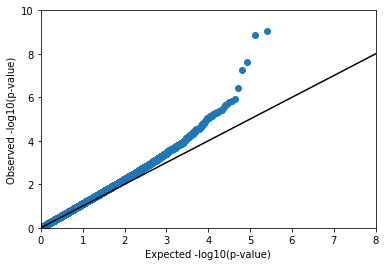

In [46]:
gwas['snp_index'] = range(len(gwas))

fig, ax = plt.subplots()

ax.scatter(gwas_sorted["uniform_logP"], gwas_sorted["logP"])
ax.plot([8,0], [8, 0], color = "black")

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.xlabel("Expected -log10(p-value)")
plt.ylabel("Observed -log10(p-value)")
    
plt.show()